In [1]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170519/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170519/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = '68298203070473-ScoobyDoo'
all_side_files_red = 'DoubleSpec/20170519/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170519/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20170519/red0081.fits') #use these to get targetid
#target[0].header
##################################################

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


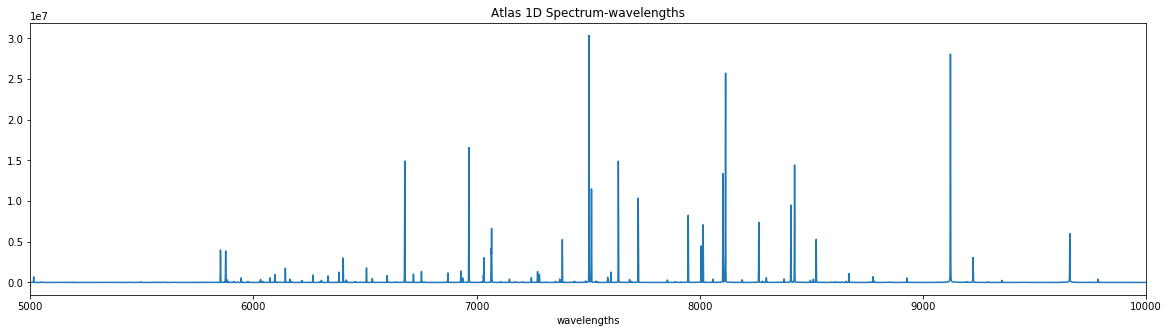

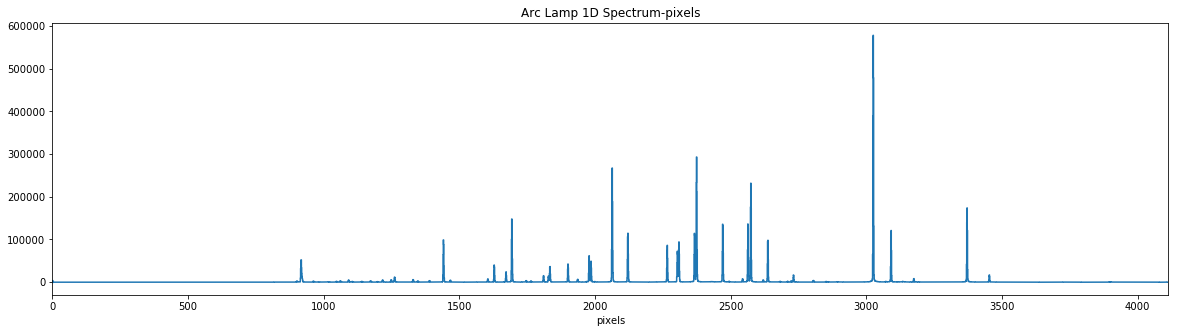

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

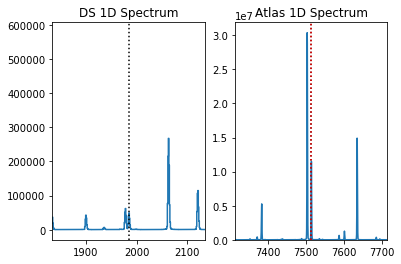

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1984,7514.106,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [3024,2373,2062,3370,1984]
atlas_lines = [9122.9674,8115.311,7635.106,9657.7863,7514.6518]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.54705220294689, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.2797688226410067, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.4990809349450942, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 0.9648946538339258, which is less than 10"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.0205842020667832, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 0.9921479492029303, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Tried to find peak at 2101.4523437501557 bu

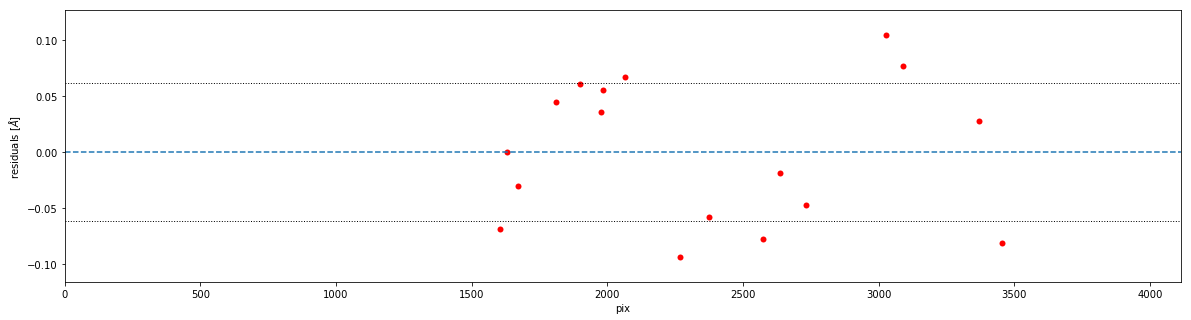

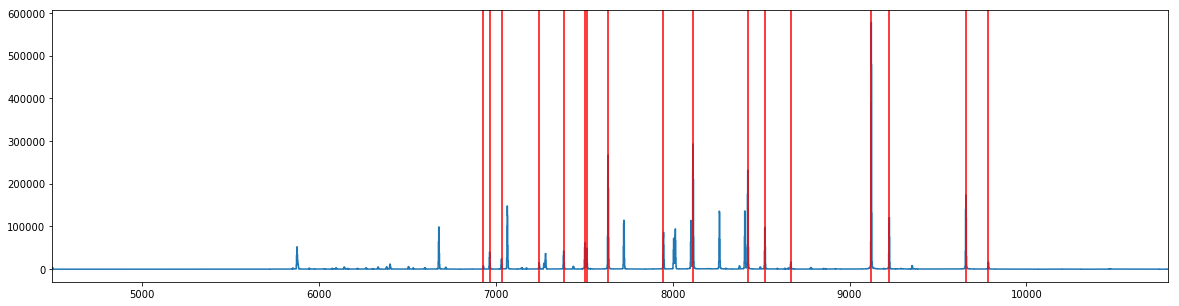

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


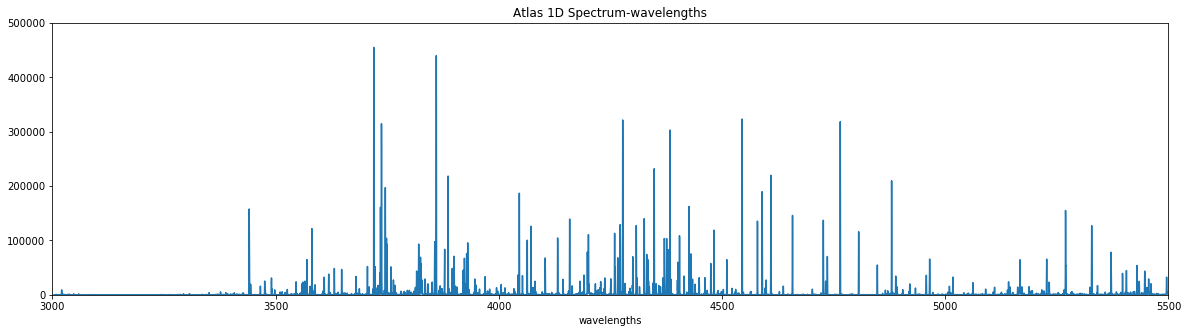

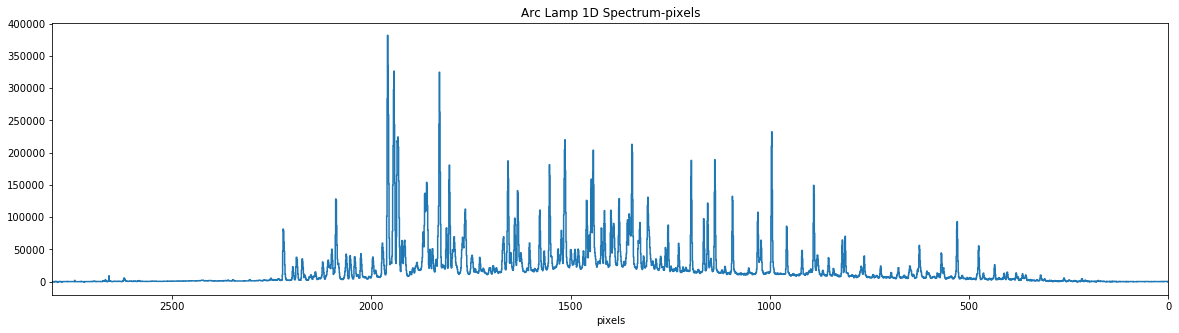

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

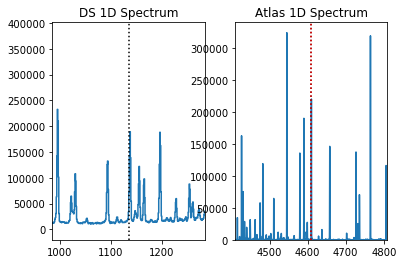

In [8]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [994,1640,1803,1957,1972,2088] 
atlas_lines = [4764.8646,4063.5939,3886.2820,3719.9346,3705.5657,3581.1925]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 0.8787756508078163, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 0.6724665945621533, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Tried to find peak at 2612.1972675189586 but it's in a valley, not a peak"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 0.9949109765217417, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 0.9189591859935498, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 0.9189591859935498, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.1644039232245977, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Tried to find peak at 2410.1141888741304 but it's in a valley, not

Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.450110822813734, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 2.0240305514411387, which is less than 5"
Failed to find line ArII at wl=4042.8937: "Tried to find peak at 1659.5581882774165 but it's in a valley, not a peak"
Failed to find line ArI at wl=4044.4179: "Guessed line's peak to base ratio is 4.756716694358505, which is less than 5"
Failed to find line FeI at wl=4045.813: "Guessed line's peak to base ratio is 4.756716694358505, which is less than 5"
Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 2.429817521709863, which is less than 5"
Found line FeI at wl=4063.5939
Clipped 0 lines
Failed to find line ArII at wl=4103.9121: "Guessed line's peak to base ratio is 3.6881492251166637, which is less than 5"
Failed to find line FeI at wl=4118.5442: "Guessed line's peak to base ratio is 1.677343698146238, which is less

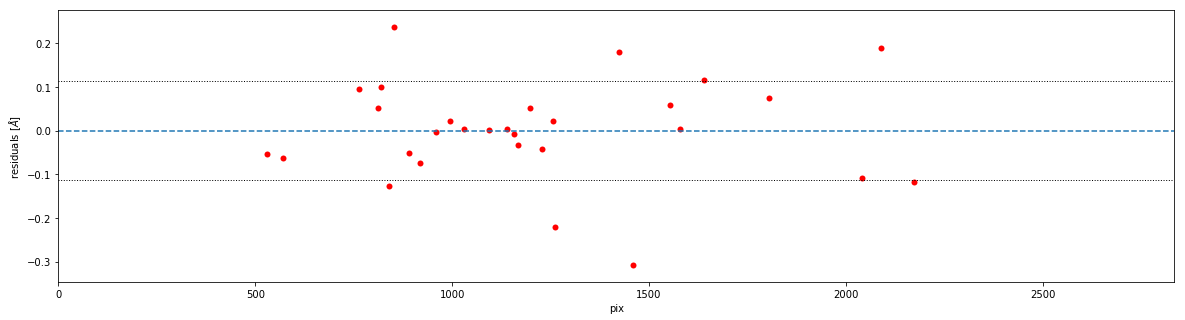

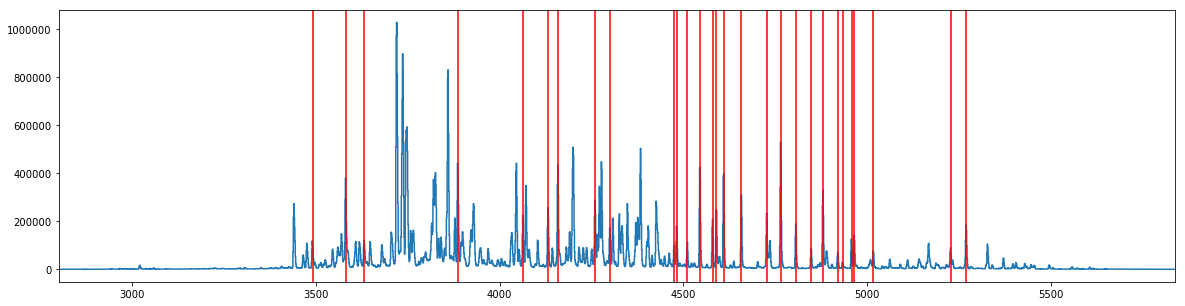

In [9]:
#creating a ds _ part three

ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


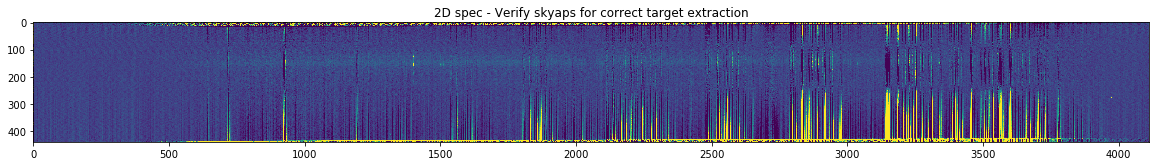

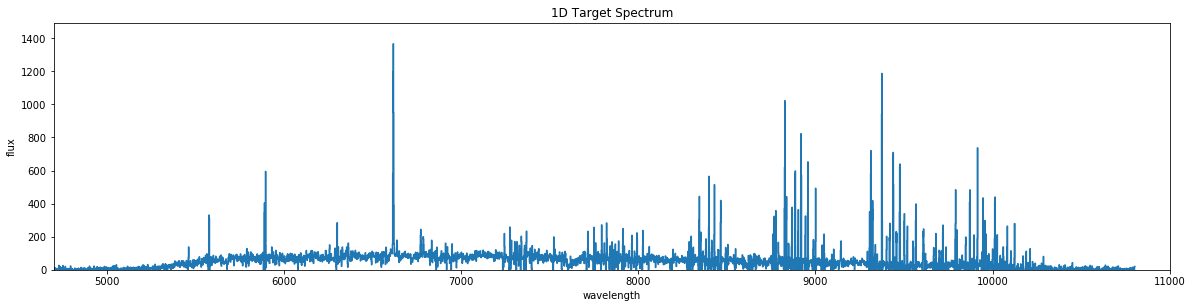

In [10]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(80,100),(235,240)]#spatial regions above & below target to estimate sky emissions
model_red= 'linear' #estimating sky line tilt
specaps_red = (140,166)#(,166)(,194)(113,225)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for blueside
choose 1D target spec axis limits for blueside


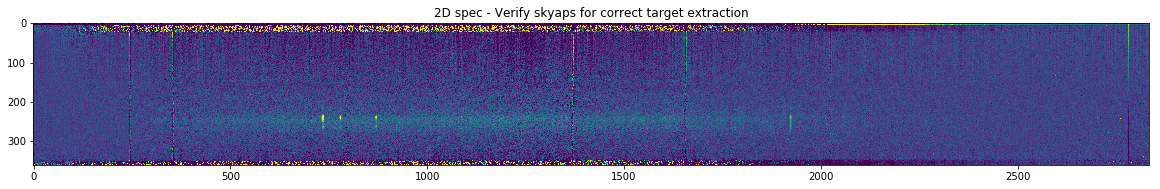

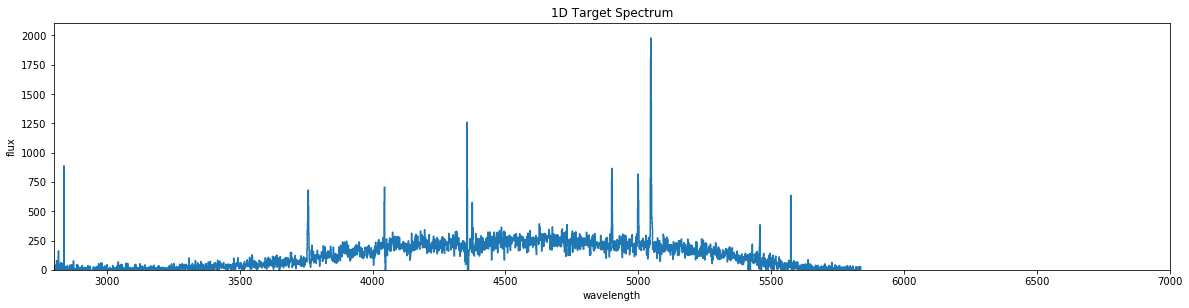

In [11]:
#BLUE side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(150,205),(290,320)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (160,260)#target spatial region #(280,316)
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

In [12]:
#host z

distance = 36.3*u.Mpc #host dist from saga paper
H0 = 70 * u.km / u.s / u.Mpc #hubble const
c = const.c.to('km/s') #speed of light
host_z = (distance * H0)/ c 

print('ScoobyDoo-host redshift:',host_z)

ScoobyDoo-host redshift: 0.008475863658985044


In [13]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (127, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


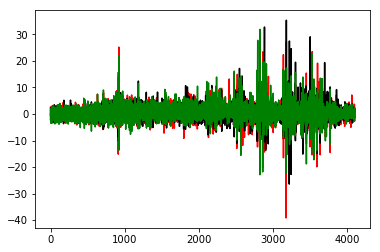

In [14]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(100,226)#(120,160)  (150,164)#target location
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[13],color='r')#near galaxy center
plt.plot(flux_data[5],color='k') #near galaxy edge
plt.plot(flux_data[9],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

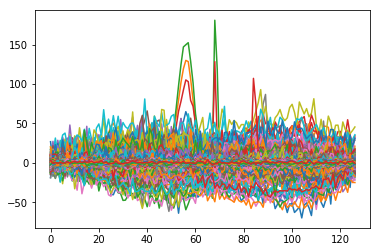

In [15]:
plt.plot(flux_data);

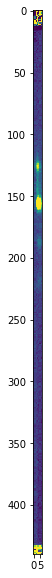

In [16]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[:,1398:1405] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1398, 1405)
bestline_range_correction = (1388,1395) 
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

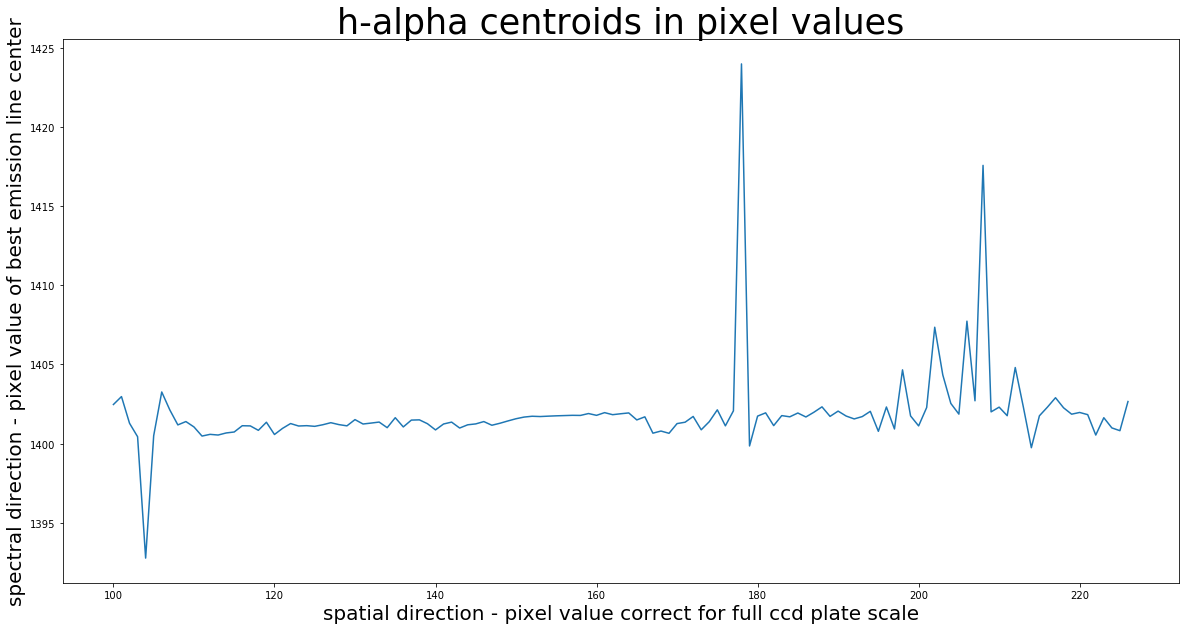

In [17]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1398:1405] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1388:1395] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels

#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################

In [18]:
#matrix fix if needed above

#takes out unc value from each matrix
#exploring means_unc problem/solution


#print('10',type(means_unc[10]))

#determining which index of matrix value i want
#print(np.shape(means_unc), 'MATRIX', means_unc[1],'SECOND ROW', means_unc[1][1], 'MIDDLE',means_unc[1][1][1])
#print('possible problem matrix here',means_unc[10])

#setting up indexing array to explore all the matrices in for loop
matrix = np.arange(0,len(means_unc),1)
print('matrix length array:', matrix)


badmatrix = np.array([ 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0])
badmatrix = np.reshape(badmatrix,(3,3))
print('testing badmatrix stuff - shape:',np.shape(badmatrix),'middle index:',badmatrix[1][1])

unc = []
uncs = [] 
badvalues = []  
    
for i in matrix:
    #np.array([means_unc])
    #empty == type(np.any(means_unc[10])) #np.bool
    #print('empty',empty)
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i)
        badvalues.append(i)
        for j in badvalues:
            means_unc[j] = badmatrix
            ##uncs.append(means_unc[j][1][1])
            #print('one replaced uncs',uncs)
            #print('replaced with', means_unc[j])
            #print('right index?', means_unc[j][1][1])
            #print('replaced type',type(means_unc[j]))
    else:
        np.all(means_unc[i]) == np.all(means_unc[i])
        #print('reg type',type(means_unc[i]),'i=',i) #np.ndarray
    uncs.append(means_unc[i][1][1]) #does same as below
    #print('one original uncs',uncs)
    
unc.append(uncs) #does same as above
print('unc',np.shape(unc),len(unc),'uncs',np.shape(uncs),len(uncs))
print('uncs best b/c of shape but unc or uncs are both same array of middle term from matrices....ie sigma**2')
#print('unc len',len(unc),'unc shape',np.shape(unc),'unc',unc)

#print("another row", 'MATRIX', means_unc[51],'SECOND ROW', means_unc[51][1], 'MIDDLE',means_unc[51][1][1])
#print('maybe uncs is best',uncs,'shape',np.shape(uncs),'length',len(uncs))

print('use uncs for means_unc')


matrix length array: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
testing badmatrix stuff - shape: (3, 3) middle index: 100.0
bad matrix at array: 3
bad matrix at array: 8
bad matrix at array: 67
bad matrix at array: 68
bad matrix at array: 73
bad matrix at array: 74
bad matrix at array: 99
bad matrix at array: 102
bad matrix at array: 104
bad matrix at array: 106
bad matrix at array: 107
bad matrix at array: 108
bad matrix at array: 109
bad matrix at array: 114
bad matrix at array: 126
unc (1, 127) 1 uncs (127,) 127
uncs 

1423.97677108
1417.57019813
[78, 108]


(1400, 1403)

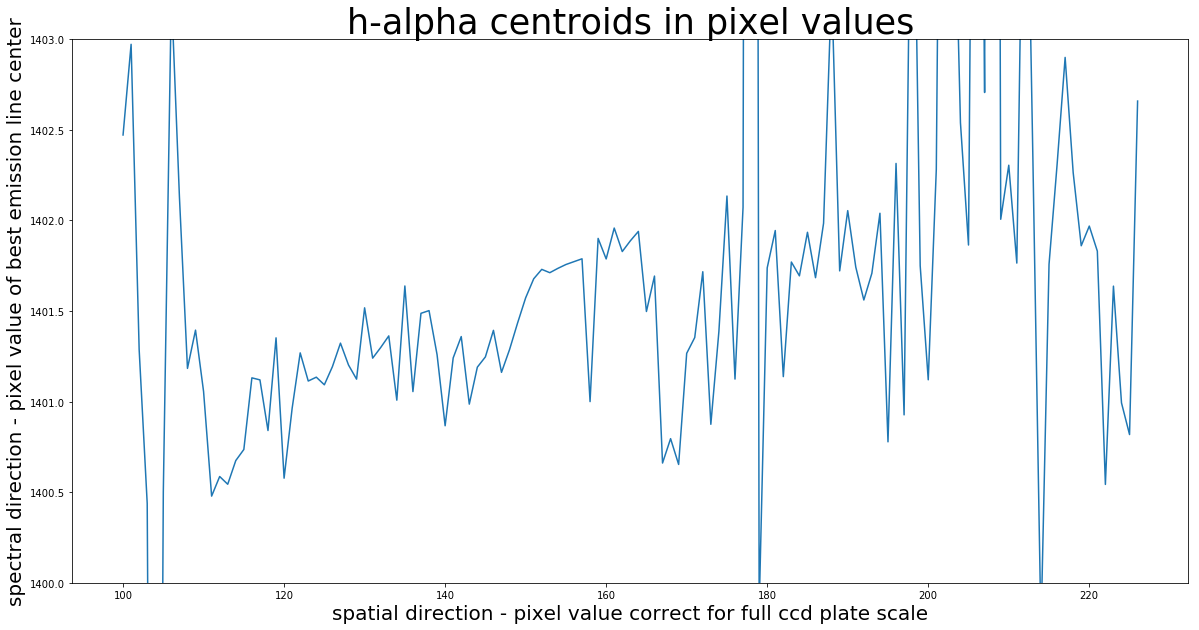

In [19]:
#avoiding bad fit areas above - bad fits due to gaps btwn knots

for i in centroid_specpix_fullccd:
    if i >= 1410:
        print(i)
#gets index of bad fit values
print([i for i,x in enumerate(centroid_specpix_fullccd) if x >= 1410])
'''
#attempt to smooth data
mylist= []
cleaned_centroids = []
for i in centroid_specpix_fullccd:
    if i >= 1410:
        #fix this shady move later
        i = 1402.#np.mean([centroid_specpix_fullccd[(i-1)],centroid_specpix_fullccd[(i+1)]])
    else: 
        i = i
    #mylist = centroid_specpix_fullccd[i]
    #print(i) #verified change happened
    cleaned_centroids = mylist.append(i)
    print(cleaned_centroids)
cleaned_centroids = np.array(cleaned_centroids)
print('before',len(centroid_specpix_fullccd))#,
print('after',len(cleaned_centroids))
'''

centroid_specpix_fullccd[58] = 1401 #b/c these are rougly the mean of pts before/after
centroid_specpix_fullccd[88] = 1403.3
#print(centroid_specpix_fullccd)


#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################
plt.ylim(1400,1403)

(1400, 1405)

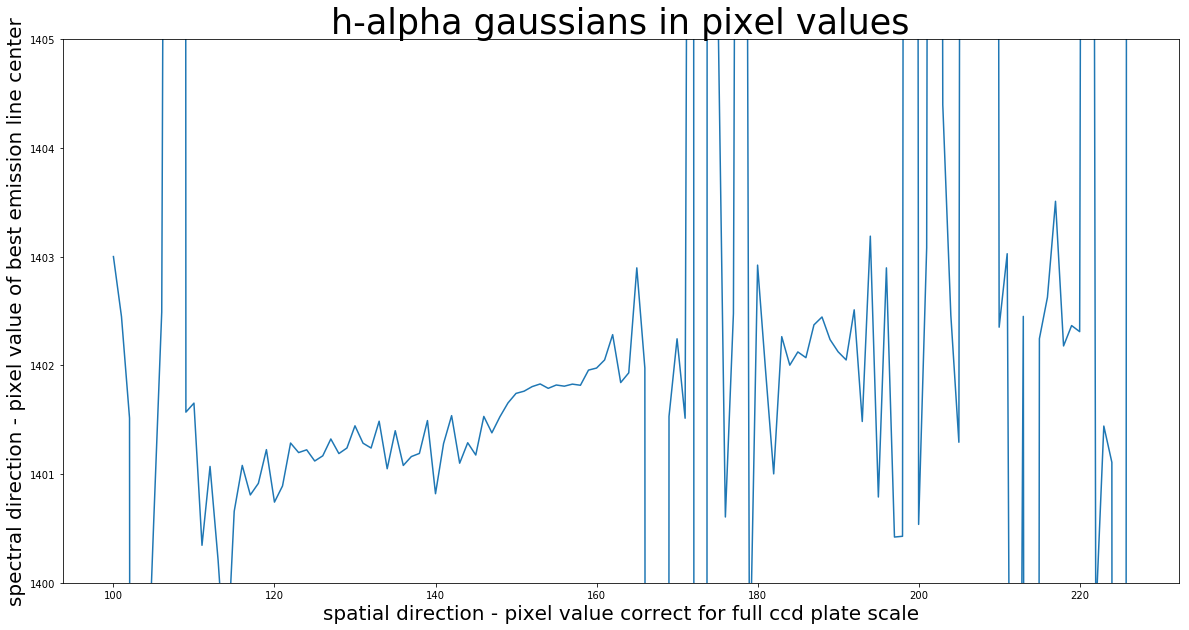

In [20]:
#gaussian values

plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha gaussians in pixel values',fontsize=35)
###########################################################
plt.ylim(1400,1405)

(6610, 6624)

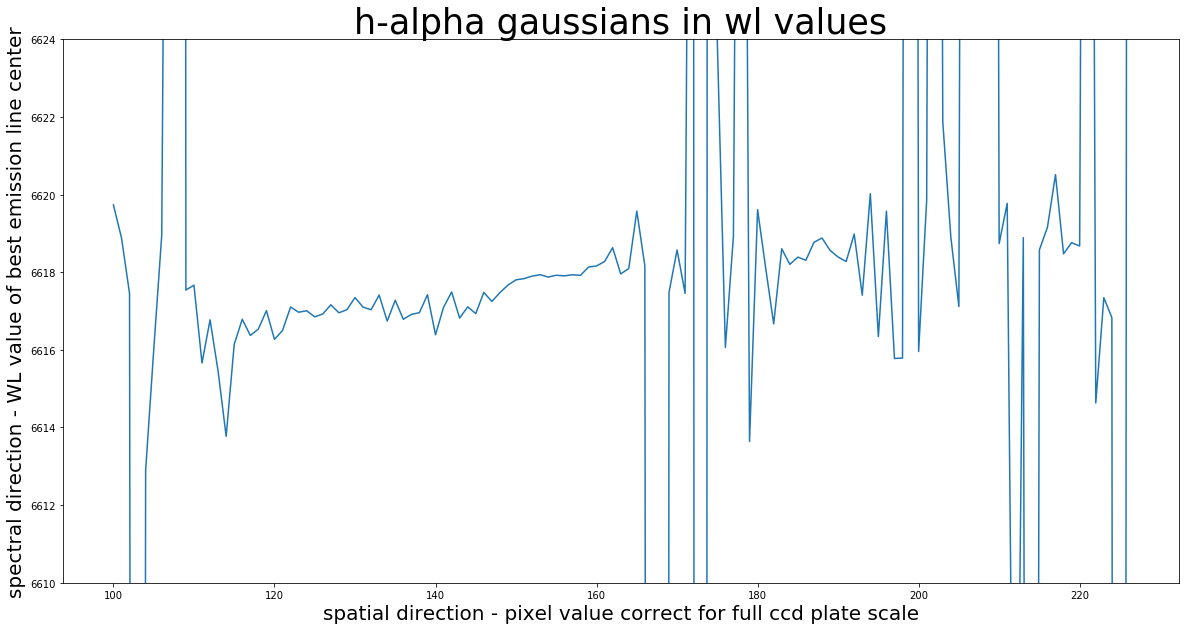

In [21]:
#converted gaussians to wl to see how much of a shift there is

#applies ds
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussians in wl values',fontsize=35)
##########################################################
plt.ylim(6610,6624)#(6609,6612)

shape of first section: (127, 50) matches shape of second section: (127, 50)
shape of first section 2d: (127, 1)
shape of second section 2d: (127, 1)
first section centroid x,y: 0.0 47.9574489868
second section centroid x,y: 0.0 49.2235342548
This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS 48.5904916208
Pixel Value of core along spatial axis wrt full CCD size 148.590491621


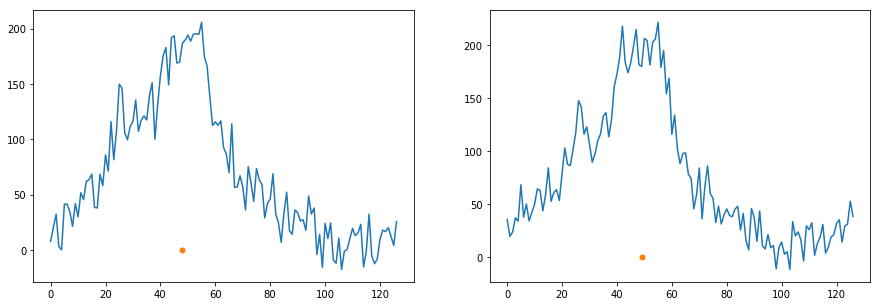

In [22]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
np.shape(flux_data)#(226,4104) #note that this is missing those wl's


#making arrays surrounding best emission line
################################################
upperha = 1399
lowerha = 1386
#################################################
width_sections = 50
upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
lower_one = upper_one - width_sections
lower_two = upperha + 1 #giving it some distance
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
x_first, y_first = centroid_com(first_section2d)
x_second, y_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

#FULL CCD pixel value of core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)




In [23]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print(bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

1401.63801672
Best emission line "core" wl (based on gaussian fits) is: 6617.643127655485 Angstrom


In [24]:
#centering around core first

#still in pixel space
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [25]:
#actual converting for loop CENTROIDS pixels to kpc
#good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 36.3*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

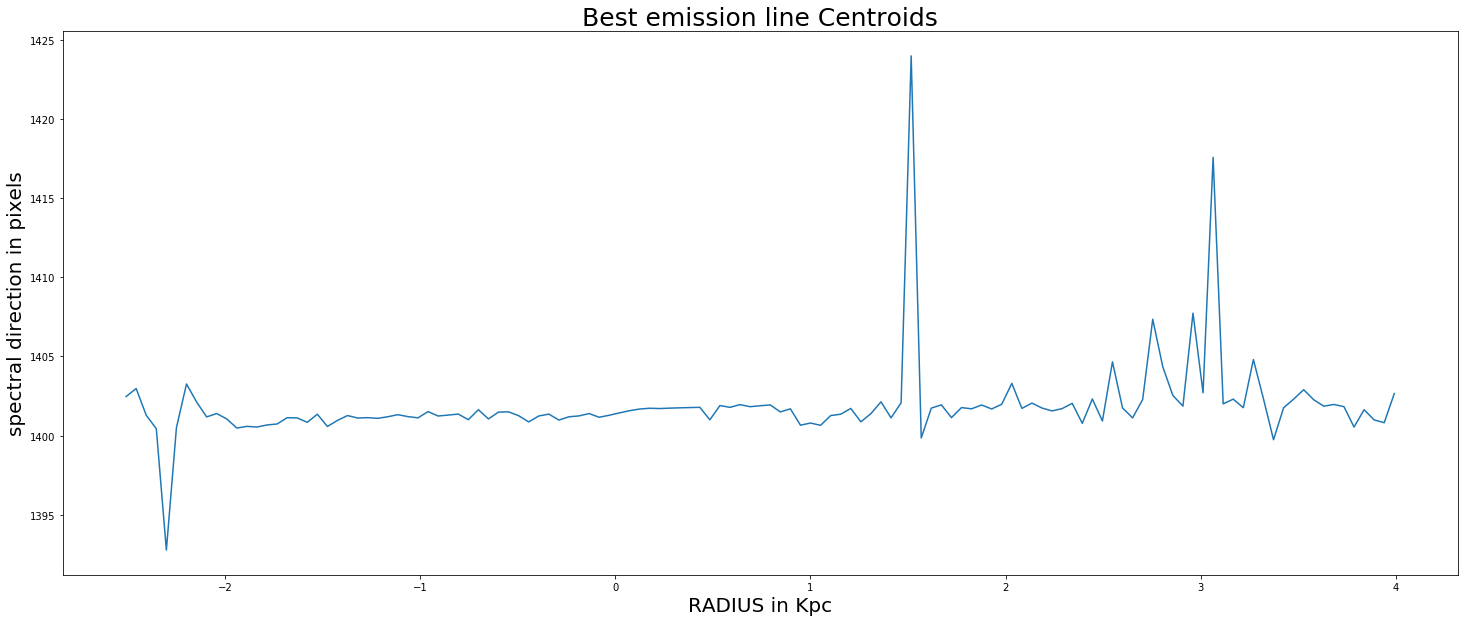

In [26]:
#CENTROID plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Centroids', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, centroid_specpix_fullccd)

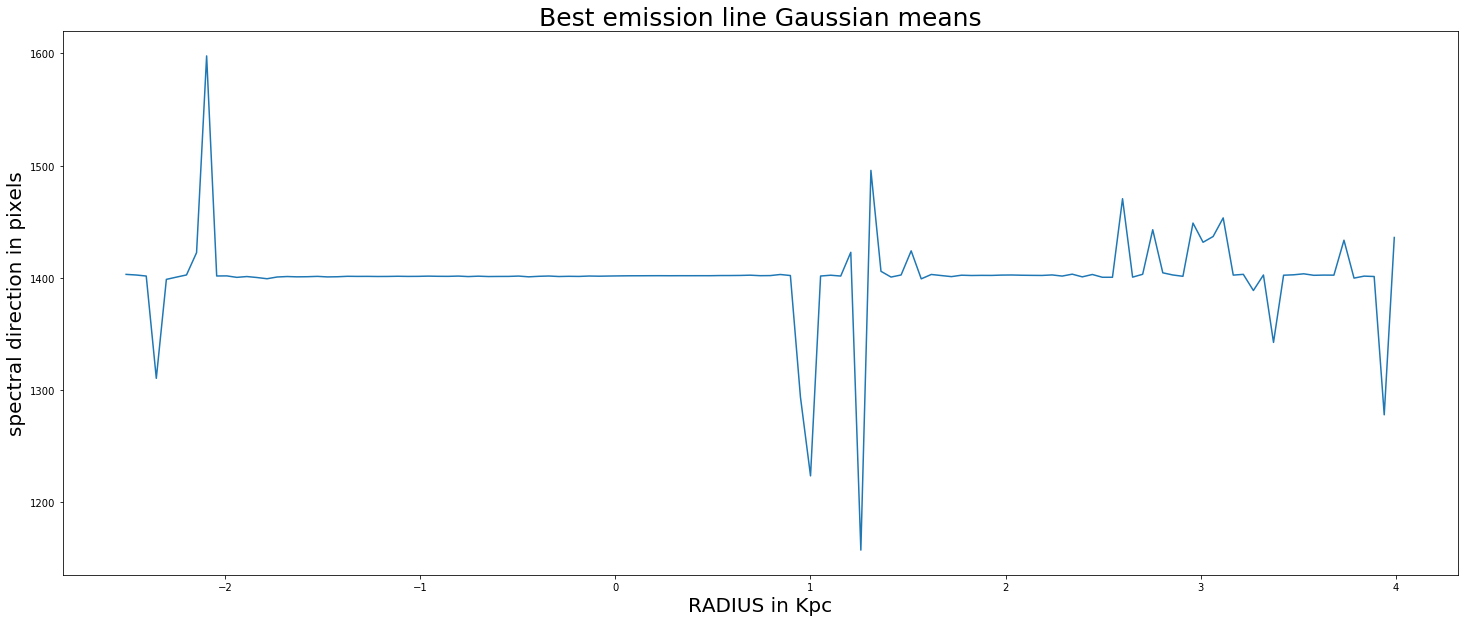

In [27]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd)

In [28]:
#convert pix to wl via ds
###################################################################
centroids_wl = ds_red.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd)*u.angstrom
core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [29]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core)

velocity of best emission line's spectral 'core': 2496053.2611070788 m / s


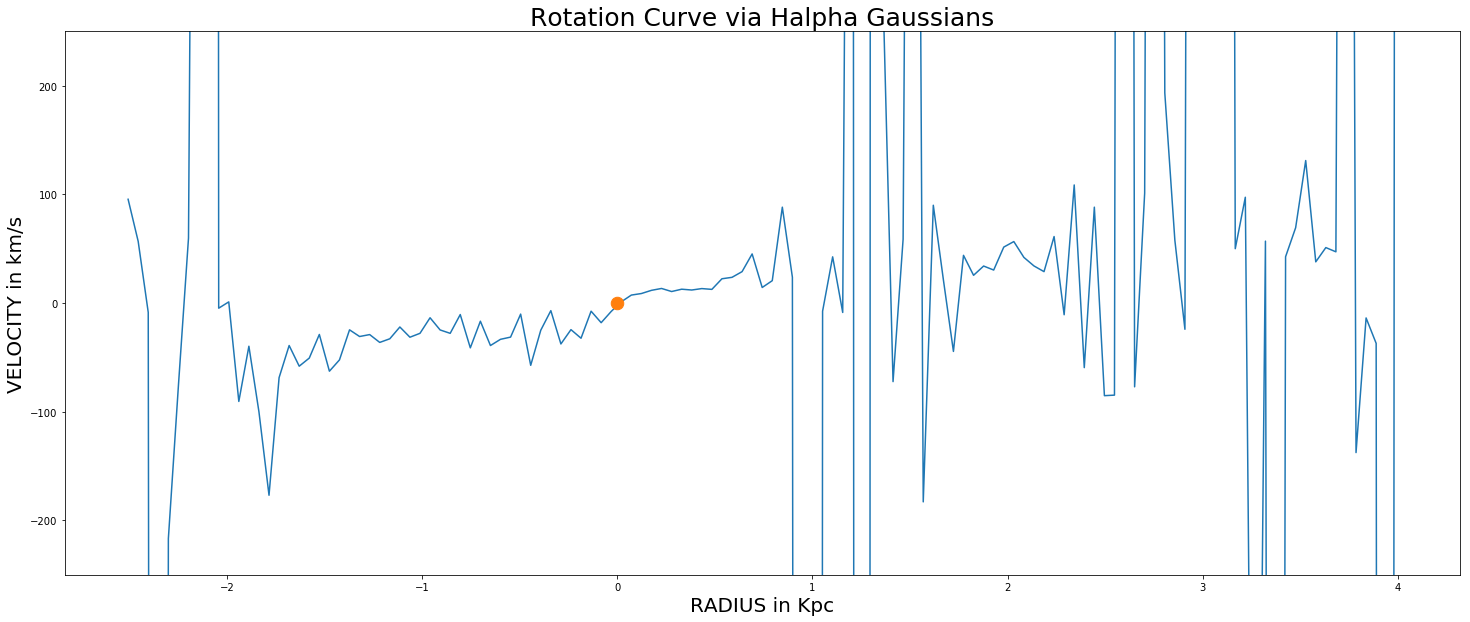

In [30]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

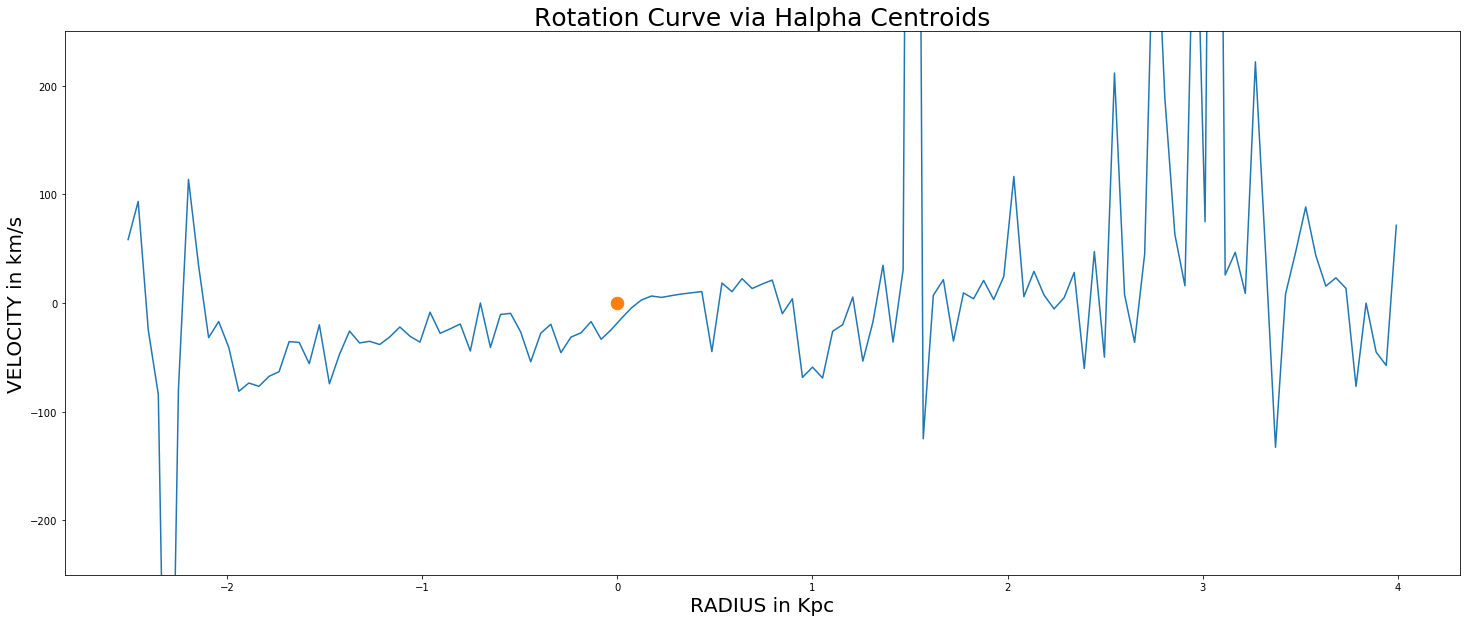

In [31]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Centroids', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Cvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

In [32]:
#using output from GAUSSIAN fit to determine error; tbd how to for CENTROIDS

#method to obtain sigma = subttract velocities of (mean+sigma) - mean = sigma 
###########################################sub uncs for means_unc if used matrix fix
sigma_gauss_pix = np.sqrt(np.abs(uncs)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
print(sigma_gauss_pix)
means_Wsigma_fullccd = gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocity

[  3.52903476e-01   1.25432792e+02   3.51957929e+00   1.00000000e+01
   1.14927207e+05   2.07785646e-01   5.05667634e-01   7.57111844e+02
   1.00000000e+01   2.66508850e+02   3.03170277e+00   2.16602882e-01
   3.90129717e-01   5.87117366e-01   1.16213137e+01   2.59034254e-01
   1.43960946e-01   3.17974342e-01   2.31896089e-01   2.19717682e-01
   2.39946068e-01   2.46842007e-01   2.23997012e-01   8.06498415e-02
   7.34426009e-02   8.11170559e-02   7.71300057e-02   4.06989034e-02
   4.64745853e-02   1.46330286e-01   2.67827962e-01   4.58957081e-02
   1.18419354e-01   2.93117997e-01   3.08517316e-01   1.99220397e-01
   2.58227896e-01   2.32122676e-01   2.61089658e-01   1.82920005e-01
   9.17787276e-02   3.09010060e-01   6.28870814e-02   1.75953226e-01
   9.02217882e-02   2.98875521e-01   1.48767635e-01   1.97049842e-01
   1.94803269e-01   1.55327616e-01   1.07140497e-01   8.13691908e-02
   1.87725125e-02   3.25781054e-02   3.11164024e-02   2.53770232e-02
   4.31598989e-02   3.16148709e-02

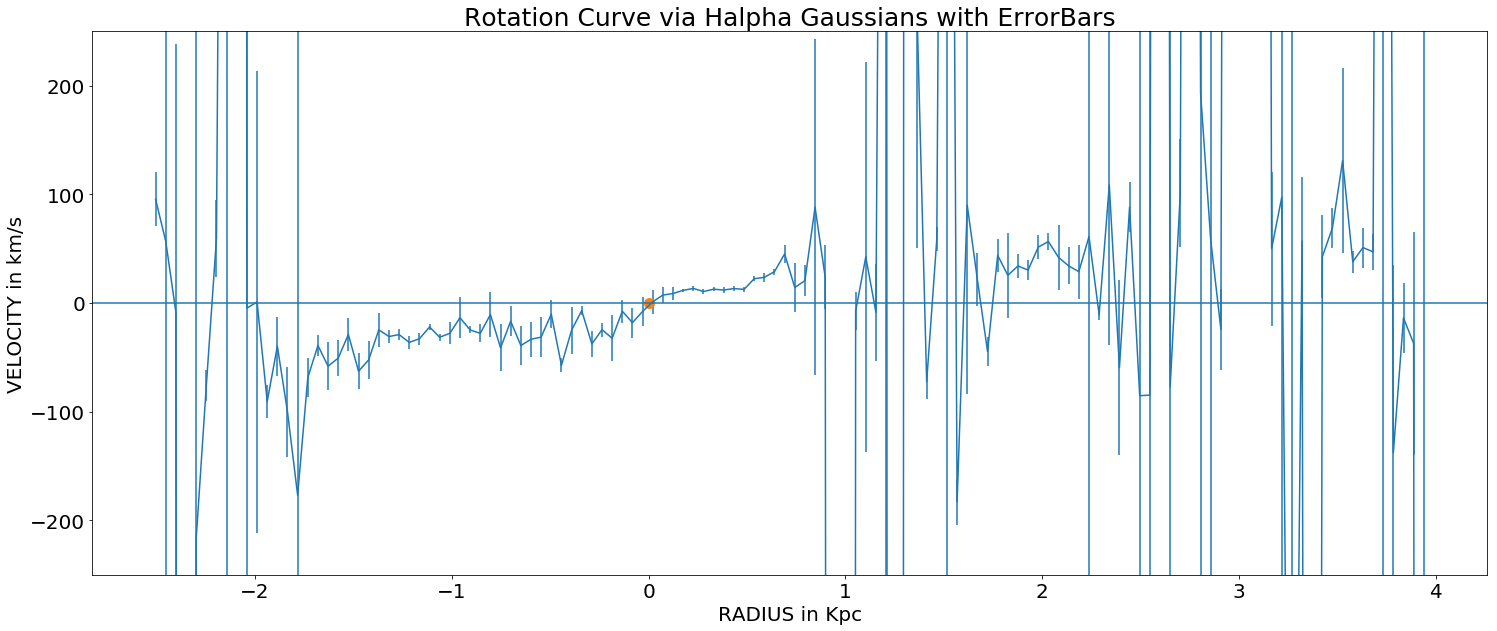

In [33]:
#rotation curve with gaussians with errorbars
plt.figure(figsize=(25,10))


arr = np.asarray #need to avoid setting array element as sequence
#had to chop last value b/c in sigma array = -inf
###############################################################################
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity[:-1]), yerr=arr(v_unc[:-1]))
###############################################################################
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)
plt.axhline(0)

[  2.47136263e+01   8.79066983e+03   2.46474404e+02   6.99494785e+02
  -1.34771757e+08   1.45506457e+01   3.54114180e+01   5.32405122e+04
   7.01941833e+02   1.86926578e+04   2.12308367e+02   1.51680525e+01
   2.73198986e+01   4.11140992e+01   8.13851772e+02   1.81394712e+01
   1.00812438e+01   2.22669375e+01   1.62391086e+01   1.53863441e+01
   1.68027929e+01   1.72857306e+01   1.56860286e+01   5.64772341e+00
   5.14301830e+00   5.68043581e+00   5.40123523e+00   2.85005464e+00
   3.25450752e+00   1.02471840e+01   1.87554584e+01   3.21397396e+00
   8.29264212e+00   2.05264834e+01   2.16047505e+01   1.39509933e+01
   1.80831005e+01   1.62550266e+01   1.82835289e+01   1.28095243e+01
   6.42702348e+00   2.16393196e+01   4.40385647e+00   1.23215930e+01
   6.31803248e+00   2.09295901e+01   1.04179045e+01   1.37989903e+01
   1.36416928e+01   1.08773045e+01   7.50285613e+00   5.69813848e+00
   1.31460556e+00   2.28138750e+00   2.17902587e+00   1.77710806e+00
   3.02241133e+00   2.21393382e+00

(-1000, 1000)

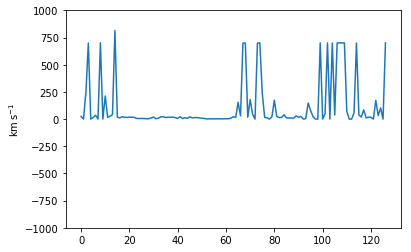

In [54]:
#adjusting weights to account for regions with bad gauss fits

print('original sigma values',v_unc)
#plt.plot(v_unc)
#plt.ylim(-1000,1000) #explored to determine a good value to set cut off b4 weights =inf
v_unc_realistic = []
for i in v_unc.value:
    if i >= 1000 or i <= -1000: #*u.s/u.km
        i = 0
    else:
        i = i #*u.s/u.km
    v_unc_realistic.append(i)
v_unc_realistic = v_unc_realistic*u.km/u.s
print('new sigma values', v_unc_realistic)
#v_unc.value
plt.plot(v_unc_realistic)
plt.ylim(-1000,1000)

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    alpha beta sigma omega
    ----- ---- ----- -----
      0.0  0.0 250.0 4e-05


/Users/dee/miniconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)


(-230, 200)

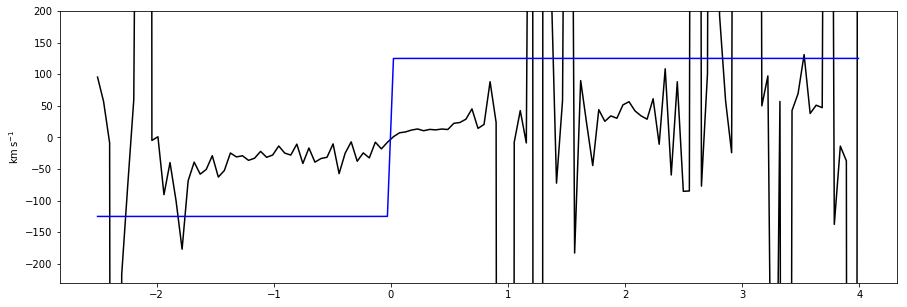

In [55]:
#eriks model eqt 5

@custom_model #very necessary line
def eriksmodel(r, alpha=.0000000000, beta=.000000, sigma=250, omega=.00004):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)


#fit model to data
m_init = eriksmodel()
fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections * u.kpc), arr(y_axis_Gvelocity),weights=arr(1/(v_unc_realistic)**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.plot(distances_sections, y_axis_Gvelocity, color='k')
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-230,200) #zooms to see data good, if fit is good
#plt.ylim(-1000,2000) #to see whole effect of param playing on fit line